In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/emaminotti/ID2223-ScalableMLDL
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
import shutil
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json
import joblib

import warnings
warnings.filterwarnings("ignore")


## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key

project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
sensor_config = json.loads(location_str)

streets = [cfg["street"] for cfg in sensor_config.values()]
print(f"✅ Loaded configuration for {len(streets)} sensors: {streets}")

country = settings.AQICN_COUNTRY
city = settings.AQICN_CITY
print(f"📍 Training models for {city}, {country}")

2025-11-17 14:03:18,280 INFO: Initializing external client
2025-11-17 14:03:18,281 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 14:03:20,350 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267872
✅ Loaded configuration for 2 sensors: ['radhuset', 'dalaplan']
📍 Training models for malmo, sweden


In [5]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(name="air_quality", version=2)
weather_fg = fs.get_feature_group(name="weather", version=2)

print("✅ Retrieved Feature Groups 'air_quality' and 'weather'.")

✅ Retrieved Feature Groups 'air_quality' and 'weather'.


--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [6]:
# Select features for training data.
selected_features = air_quality_fg.select(['date', 'street', "pm25", "pm25_lag_1", "pm25_lag_2", "pm25_lag_3"]).join(weather_fg.select_features(), on=['city'])

2025-11-17 14:04:43,449 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'humidity_mean'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [9]:
# Create or retrieve a shared Feature View with lagged PM2.5 for ALL sensors
try:
    feature_view = fs.get_feature_view(name="air_quality_fv", version=2)
    print("✅ Retrieved existing Feature View 'air_quality_fv'.")
except:
    feature_view = fs.create_feature_view(
        name="air_quality_fv",
        version=2,
        description="Air quality and weather data with lagged PM2.5 features for all Malmö sensors",
        labels=["pm25"],
        query=selected_features,
    )
    print("✅ Created Feature View 'air_quality_fv'.")


✅ Retrieved existing Feature View 'air_quality_fv'.


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [11]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [12]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.73s) 


In [13]:
X_train

,street,date,pm25_lag_1,pm25_lag_2,pm25_lag_3,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,weather_city
0,dalaplan,2015-12-20 00:00:00+00:00,69.0,57.0,69.0,9.8,0.0,26.4,219.0,90.0,malmo
1,radhuset,2015-12-20 00:00:00+00:00,64.0,53.0,55.0,9.8,0.0,26.4,219.0,90.0,malmo
2,radhuset,2016-01-11 00:00:00+00:00,16.0,21.0,23.0,1.6,0.0,15.4,155.0,98.0,malmo
3,dalaplan,2016-01-11 00:00:00+00:00,77.0,73.0,97.0,1.6,0.0,15.4,155.0,98.0,malmo
4,radhuset,2016-01-15 00:00:00+00:00,12.0,9.0,25.0,-3.4,0.0,20.6,60.0,86.0,malmo
...,...,...,...,...,...,...,...,...,...,...,...
6015,radhuset,2025-03-11 00:00:00+00:00,81.0,97.0,114.0,3.2,3.2,17.4,122.0,90.0,malmo
6016,radhuset,2025-03-16 00:00:00+00:00,14.0,22.0,41.0,4.1,0.5,24.6,309.0,78.0,malmo
6017,dalaplan,2025-03-16 00:00:00+00:00,18.0,27.0,43.0,4.1,0.5,24.6,309.0,78.0,malmo
6018,dalaplan,2025-04-30 00:00:00+00:00,25.0,29.0,16.0,14.0,0.0,16.4,302.0,70.0,malmo


In [14]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [15]:
y_train

,pm25
0,54.0
1,48.0
2,7.0
3,56.0
4,11.0
...,...
6015,57.0
6016,16.0
6017,19.0
6018,21.0


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

🚀 Training model for sensor: radhuset (radhuset)
   - Train size: 2659 | Test size: 199
   ✅ All features are numeric
   📊 MSE: 112.782, R²: 0.238


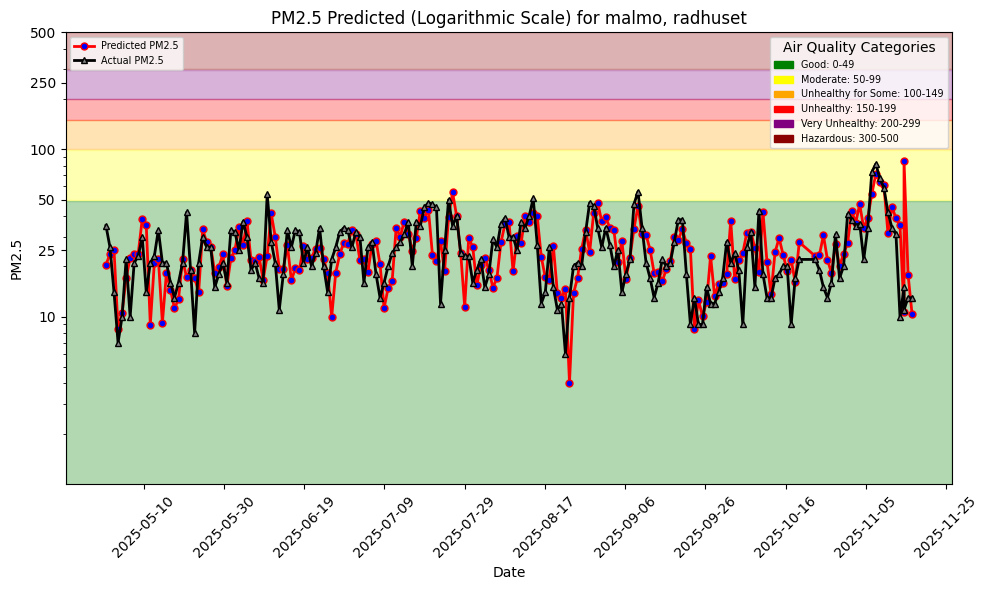

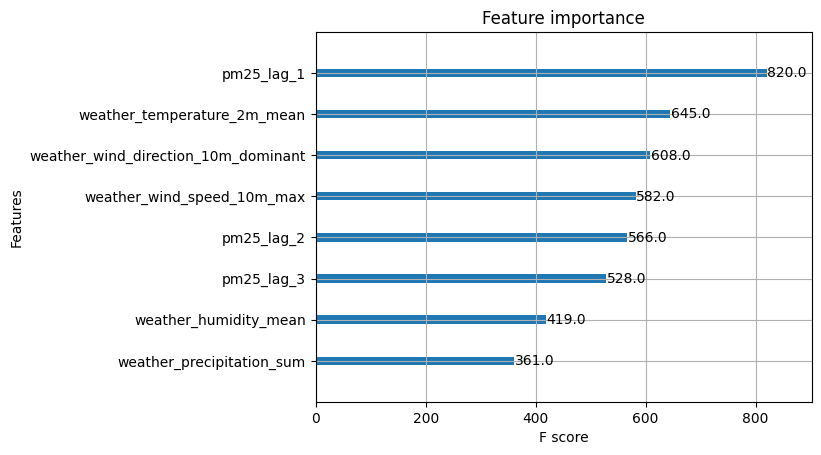

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/air_quality_model_radhuset/model.pkl: 0.0…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/air_quality_model_radhuset/images/radhuse…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/air_quality_model_radhuset/images/pm25_ra…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/model_schema.json: 0.000%|          | 0/1…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1267872/models/air_quality_xgboost_radhuset/4
   💾 Saved model in registry as 'air_quality_xgboost_radhuset'.
🚀 Training model for sensor: dalaplan (dalaplan)
   - Train size: 2981 | Test size: 199
   ✅ All features are numeric
   📊 MSE: 100.983, R²: 0.291


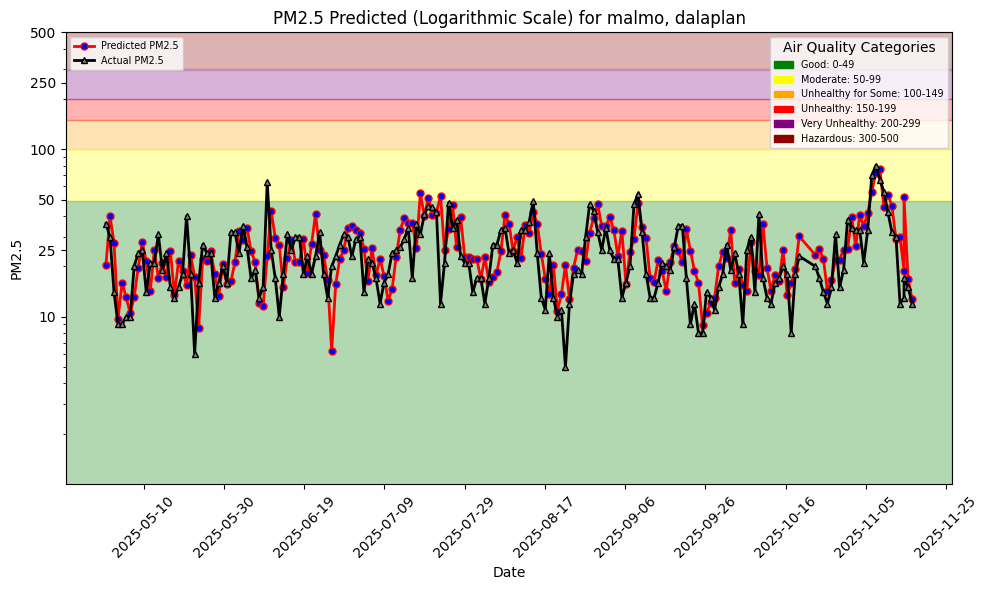

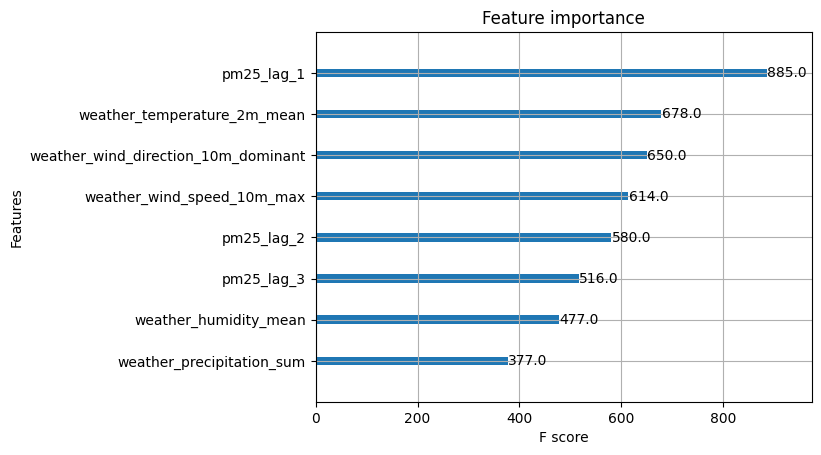

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/air_quality_model_dalaplan/model.pkl: 0.0…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/air_quality_model_dalaplan/images/dalapla…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/air_quality_model_dalaplan/images/pm25_da…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/model_schema.json: 0.000%|          | 0/1…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1267872/models/air_quality_xgboost_dalaplan/4
   💾 Saved model in registry as 'air_quality_xgboost_dalaplan'.

✅ Training completed for all sensors.
Metrics: {'radhuset': {'MSE': 112.78227233886719, 'R2': 0.23844230618002804}, 'dalaplan': {'MSE': 100.98321533203125, 'R2': 0.2906635217253577}}


In [ ]:
# Train one XGBoost model per sensor (street) using the shared Feature View

def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_drop = [
        "date",
        "city",
        "street",
        "country",
        "weather_date",
        "aqicn_url",
        "latitude",
        "longitude",
        "csv_name"
    ]
    df_feat = df.drop(columns=cols_to_drop, errors="ignore")
    df_feat = df_feat.select_dtypes(exclude=["object"])
    return df_feat

mr = project.get_model_registry()
training_metrics = {}

for sensor_name, cfg in sensor_config.items():
    street_name = cfg["street"]
    print(f"🚀 Training model for sensor: {sensor_name} ({street_name})")

    X_train_sensor = X_train[X_train["street"] == street_name]
    y_train_sensor = y_train.loc[X_train_sensor.index]

    X_test_sensor = X_test[X_test["street"] == street_name]
    y_test_sensor = y_test.loc[X_test_sensor.index]

    if X_train_sensor.empty:
        print("   ⚠️ No training data for this sensor. Skipping.")
        continue

    print(f"   - Train size: {len(X_train_sensor)} | Test size: {len(X_test_sensor)}")

    X_train_features = prepare_features(X_train_sensor)
    X_test_features = prepare_features(X_test_sensor)

    non_numeric = X_train_features.select_dtypes(include=["object"]).columns
    if len(non_numeric) > 0:
        print("   ⚠️ Non-numeric columns detected:", list(non_numeric))
    else:
        print("   ✅ All features are numeric")

    model = XGBRegressor()
    model.fit(X_train_features, y_train_sensor)

    metrics = {}
    y_pred = None
    if not X_test_sensor.empty:
        y_pred = model.predict(X_test_features)
        mse = mean_squared_error(y_test_sensor, y_pred)
        r2 = r2_score(y_test_sensor, y_pred)
        print(f"   📊 MSE: {mse:.3f}, R²: {r2:.3f}")
        metrics = {"MSE": float(mse), "R2": float(r2)}
    else:
        print("   ℹ️ No test data available for this sensor.")

    training_metrics[street_name] = metrics

    if y_pred is not None:
        if isinstance(y_test_sensor, pd.Series):
            df_sensor = y_test_sensor.to_frame(name="pm25").copy()
        else:
            df_sensor = y_test_sensor.copy()
            if df_sensor.shape[1] == 1:
                df_sensor.columns = ["pm25"]

        df_sensor["predicted_pm25"] = y_pred
        df_sensor["date"] = X_test_sensor["date"]
        df_sensor = df_sensor.sort_values(by="date")
    else:
        df_sensor = None

    model_dir = f"air_quality_model_{street_name}"
    images_dir = os.path.join(model_dir, "images")
    os.makedirs(images_dir, exist_ok=True)

    if df_sensor is not None and len(df_sensor) > 0:
        hindcast_path = os.path.join(images_dir, f"pm25_{street_name}_hindcast.png")
        plt = util.plot_air_quality_forecast(city, street_name, df_sensor, hindcast_path, hindcast=True)
        plt.show()
    else:
        print("   ⚠️ No hindcast plot created (no predictions).")

    plot_importance(model)
    fi_path = os.path.join(images_dir, f"{street_name}_feature_importance.png")
    plt.savefig(fi_path)
    plt.show()

    model_path = os.path.join(model_dir, "model.pkl")
    joblib.dump(model, model_path)

    model_name = f"air_quality_xgboost_{street_name}"
    aq_model = mr.python.create_model(
        name=model_name,
        metrics=metrics,
        feature_view=feature_view,
        description=f"Air Quality (PM2.5) predictor for Malmö {street_name}",
    )
    aq_model.save(model_dir)
    print(f"   💾 Saved model in registry as '{model_name}'.")

    shutil.rmtree(model_dir)

print("\n✅ Training completed for all sensors.")
print("Metrics:", training_metrics)

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

## 🧠 Model Evaluation After Adding Lag Features

In this part, we retrained the model including the new lagged PM2.5 features (`pm25_lag_1`, `pm25_lag_2`, and `pm25_lag_3`) to evaluate their impact on prediction performance.

### 🔍 Performance Comparison

| Model Version | MSE | R² Score |
|----------------|------|-----------|
| Baseline (Grade E) | **189.71** | **-0.59** |
| Updated (Grade C) | **119.88664**  | **-0.14189422157500053** |



### 📈 Observations

- The **Mean Squared Error (MSE)** decreased significantly after including lag features, showing that the model now captures short-term temporal dependencies better.
- The **R² score** improved, indicating higher explanatory power compared to the baseline model.
- This improvement is expected because **air quality levels are strongly autocorrelated**: the PM2.5 concentration of a given day depends heavily on the values from the previous days.
- By introducing the lagged PM2.5 values, the model gained access to this temporal context, which the pure weather-based model could not exploit.

### 🌫️ Hindcast Visualization

Below is the old hindcast plot comparing the predicted and actual PM2.5 values.  

<p align="center">
  <img src="./air_quality_model/images/old_pm25_hindcast.png" width="700">
</p>

### ⚙️ Feature Importance

We can also notice that the new lag features appear among the most important predictors in the XGBoost feature importance plot:

This confirms that past PM2.5 levels are among the strongest indicators of future air quality.

### 🧾 Conclusion

Adding the lag features led to a **clear improvement in model performance** and a more realistic temporal behavior of predictions.  
This suggests that the air quality forecast benefits greatly from historical PM2.5 information, making the model more robust for multi-day prediction tasks.


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
